# Lightkurve periodogram & power-spectrum notebook

This notebook is generated for your data file `tic437011608flattened-2min.csv`.

It will:

1. Load the CSV (expected columns: `Time (BJD-2457000)`, `Flux`, `Flattened Flux`).
2. Use the **Flattened Flux** column for transit search (BLS) and Lomb–Scargle comparison.
3. Run an automatic duration scan for BLS (durations = 0.005 → 0.5 days by default) and search
   periods from 0.5 to 25 days.
4. Plot BLS periodogram (power vs period), Lomb–Scargle periodogram (power vs period), spectral window,
   and a folded (phase) light curve at the best period.

_Tips: change `DATA_PATH` to point to your CSV if it's not in the notebook's working directory._

Generated: 2025-09-11 17:12 UTC

---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.timeseries import LombScargle
# Lightkurve provides convenience utilities; we will use it for folding & an alternative BLS implementation.
try:
    import lightkurve as lk
except Exception as e:
    print('lightkurve is not available. Please install with `pip install lightkurve` to enable some cells. Error:', e)

# Notebook defaults for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,4)


In [2]:
# === EDIT THIS PATH IF YOUR FILE IS LOCATED ELSEWHERE ===
DATA_PATH = "../data/tic437011608flattened-2min.csv"

# Read CSV — handle headers with parentheses/spaces robustly
df = pd.read_csv(DATA_PATH)
print('Columns found:', df.columns.tolist())
display(df.head())

# Typical column names from your example: 'Time (BJD-2457000)', 'Flux', 'Flattened Flux'
time_col_candidates = [c for c in df.columns if 'time' in c.lower() or 'bjd' in c.lower()]
flux_col_candidates = [c for c in df.columns if 'flatten' in c.lower() or 'flux'==c.lower() or 'flux ' in c.lower()]

print('Detected time columns candidates:', time_col_candidates)
print('Detected flux columns candidates:', flux_col_candidates)

# Choose defaults based on your input; update if your file uses different names
time_col = time_col_candidates[0] if time_col_candidates else df.columns[0]
# prefer 'Flattened Flux' if present
if any('flatten' in c.lower() for c in df.columns):
    flux_col = [c for c in df.columns if 'flatten' in c.lower()][0]
else:
    flux_col = flux_col_candidates[0] if flux_col_candidates else df.columns[1]

# parse arrays
time_rel = df[time_col].values.astype(float)   # this is BJD - 2457000 per your header
time_bjd = time_rel + 2457000.0               # absolute BJD (useful if you want absolute times)
flux = df[flux_col].values.astype(float)

print(f"Using time column: '{time_col}' (interpreted as BJD-2457000).")
print(f"Using flux column: '{flux_col}'.")
print(f"Number of points: {len(time_rel)}")


Columns found: ['Time (BJD-2457000)', ' Flux', ' Flattened Flux']


,Time (BJD-2457000),Flux,Flattened Flux
0,2500.195650,1.001089,1.000679
1,2500.197039,0.999310,0.998884
2,2500.198428,1.000477,1.000036
3,2500.199817,1.000212,0.999755
4,2500.201206,0.999567,0.999095


Detected time columns candidates: ['Time (BJD-2457000)']
Detected flux columns candidates: [' Flattened Flux']
Using time column: 'Time (BJD-2457000)' (interpreted as BJD-2457000).
Using flux column: ' Flattened Flux'.
Number of points: 32114


In [3]:
# Create a LightKurve LightCurve object (works with lightkurve installed)
try:
    lc = lk.LightCurve(time=time_rel, flux=flux)   # relative time in days is fine for period search
    display(lc.normalize().to_pandas().head())
    print('LightCurve object created.')
except Exception as e:
    print('lightkurve is not available or failed to create LightCurve object:', e)
    lc = None


,flux,flux_err
time,,
2500.195650,1.000691,NaN
2500.197039,0.998896,NaN
2500.198428,1.000048,NaN
2500.199817,0.999768,NaN
2500.201206,0.999108,NaN


LightCurve object created.


Attempting Lightkurve BLS (this will internally scan durations if supported)...
Lightkurve BLS failed or not available: Line2D.set() got an unexpected keyword argument 'annotation'
Computing BLS autopower (this may take some time) — durations grid length: 50


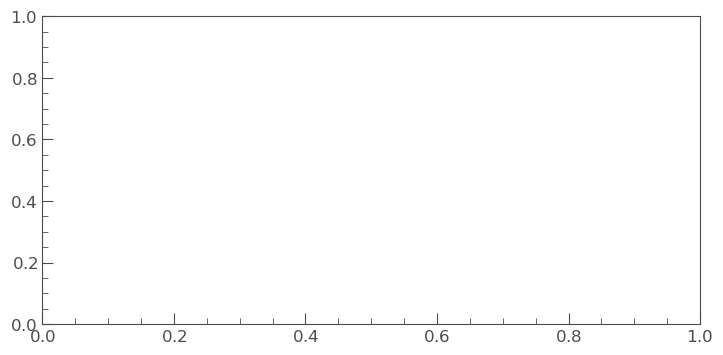

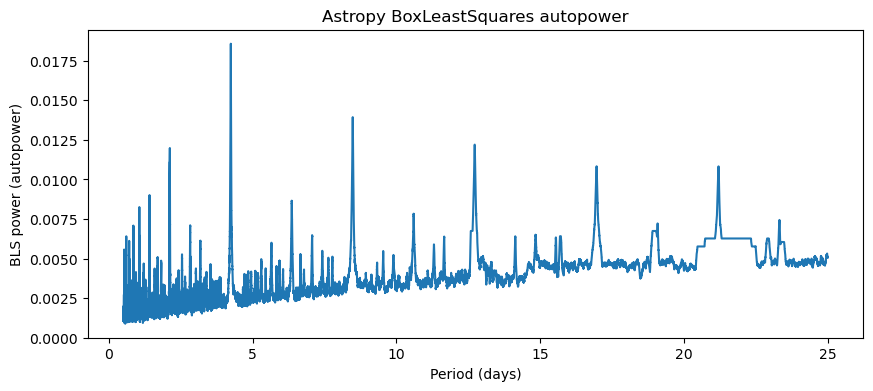

Astropy BLS best period: 4.240238205004121 best duration (days): 0.105


In [5]:
# ----- BLS (Box Least Squares) search with an automatic duration scan -----
# Period grid
min_period = 0.5    # days
max_period = 25.0   # days
n_periods = 20000   # coarse default; reduce if running on a laptop

# Duration grid (automatic scan) in days: 0.005 -> 0.5 days ~ (7 min -> 12 hr)
durations = np.linspace(0.005, 0.25, 50)

# Use lightkurve's to_periodogram (if available) OR astropy's BoxLeastSquares via an autopower-like approach
if ('lc' in globals()) and (lc is not None):
    try:
        print('Attempting Lightkurve BLS (this will internally scan durations if supported)...')
        bls_pg = lc.to_periodogram(method='bls', minimum_period=min_period, maximum_period=max_period)
        fig = bls_pg.plot(view='period', annotation=False)  # period vs power
        plt.title('Lightkurve BLS periodogram (period on x-axis)')
        plt.show()
        best_period_lk = bls_pg.period_at_max_power
        print('Lightkurve BLS best period:', best_period_lk)
    except Exception as e:
        print('Lightkurve BLS failed or not available:', e)
        bls_pg = None
        best_period_lk = None
else:
    print('Lightkurve not available; skipping lightkurve BLS.')

# Use Astropy's BoxLeastSquares via a "manual" autopower approach if astropy is available.
try:
    from astropy.timeseries import BoxLeastSquares
    periods = np.linspace(min_period, max_period, n_periods)
    bls = BoxLeastSquares(time_rel, flux)
    print('Computing BLS autopower (this may take some time) — durations grid length:', len(durations))
    # BoxLeastSquares.autopower will compute best power and duration for each trial period automatically.
    # Using `autopower` is preferred if available in your astropy version:
    try:
        bls_result = bls.autopower(durations, minimum_period=min_period, maximum_period=max_period, objective='snr')
        # bls_result contains .period, .power, .duration, .transit_time etc. (api depends on astropy version)
        plt.figure()
        plt.plot(bls_result.period, bls_result.power)
        plt.xlabel('Period (days)')
        plt.ylabel('BLS power (autopower)')
        plt.title('Astropy BoxLeastSquares autopower')
        plt.show()
        # Find best index
        best_idx = np.nanargmax(bls_result.power)
        best_period_astropy = bls_result.period[best_idx]
        best_duration_astropy = bls_result.duration[best_idx]
        print('Astropy BLS best period:', best_period_astropy, 'best duration (days):', best_duration_astropy)
    except Exception as e:
        # Fallback: compute power for each period for a fixed duration grid is expensive; provide guidance.
        print('autopower is not available in your astropy version or failed:', e)
        print('If `autopower` is not supported, consider upgrading astropy (>=4.x).')
        bls_result = None
        best_period_astropy = None
except Exception as e:
    print('Astropy BoxLeastSquares not available or failed:', e)
    bls_result = None
    best_period_astropy = None



In [ ]:
# ----- Lomb-Scargle periodogram (useful for sinusoidal signals / diagnostics) -----
min_freq = 1.0 / max_period
max_freq = 1.0 / min_period

# Use Astropy LombScargle.autopower to get a good frequency grid
ls = LombScargle(time_rel, flux)
frequency, power = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=10)

periods_ls = 1.0 / frequency

plt.figure()
plt.plot(periods_ls, power)
plt.xlim(max_period, min_period)  # show short periods on the right like typical periodograms (optional)
plt.xlabel('Period (days)')
plt.ylabel('Lomb-Scargle power')
plt.title('Lomb-Scargle Periodogram (Astropy)')
plt.show()

best_idx_ls = np.nanargmax(power)
best_period_ls = periods_ls[best_idx_ls]
print('Lomb-Scargle best period (max power):', best_period_ls)


In [ ]:
# ----- Spectral window (sampling function) -----
# A simple approach: compute LS power of a unit signal sampled at the observation times
unit_signal = np.ones_like(time_rel)
ls_window = LombScargle(time_rel, unit_signal)
freq_w, power_w = ls_window.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=5)
period_w = 1.0 / freq_w

plt.figure()
plt.plot(period_w, power_w)
plt.xlim(max_period, min_period)
plt.xlabel('Period (days)')
plt.ylabel('Window power (sampling)')
plt.title('Spectral Window (sampling) — peaks here indicate potential aliases')
plt.show()


In [ ]:
from scipy import stats
# ----- Fold the light curve at best period and plot a binned phase curve -----
# Choose best period priority: astropy BLS -> lightkurve BLS -> LS
if 'best_period_astropy' in globals() and (best_period_astropy is not None):
    best_period = best_period_astropy
elif 'best_period_lk' in globals() and (best_period_lk is not None):
    best_period = best_period_lk.value if hasattr(best_period_lk, 'value') else best_period_lk
else:
    best_period = best_period_ls if 'best_period_ls' in globals() else None

print('Using best period for folding:', best_period)

if best_period is not None:
    # Quick phase folding using numpy
    phase = ((time_rel % best_period) / best_period)
    # shift to center transit at phase=0.5 for plotting convenience
    phase = (phase + 0.5) % 1.0
    # sort by phase
    order = np.argsort(phase)
    p_sorted = phase[order]
    f_sorted = flux[order]

    plt.figure(figsize=(8,4))
    plt.plot(p_sorted, f_sorted, '.', markersize=3, alpha=0.6)
    # overplot a binned median curve to highlight transit
    bins = 100
    bin_means, bin_edges, binnumber = stats.binned_statistic(p_sorted, f_sorted, statistic='median', bins=bins)
    bin_centers = 0.5*(bin_edges[:-1]+bin_edges[1:])
    plt.plot(bin_centers, bin_means, '-k', linewidth=1)
    plt.xlabel('Phase (folded)')
    plt.ylabel('Flux (Flattened)')
    plt.title(f'Folded light curve at period = {best_period:.6f} days')
    plt.xlim(0,1)
    plt.show()
else:
    print('No best period found yet. Run the periodogram cells first.')


In [ ]:
# Optionally save figures and best-fit results
# Example: save best period(s) to a small text file
results = {}
if 'best_period_astropy' in globals() and best_period_astropy is not None:
    results['best_period_bls_astropy'] = float(best_period_astropy)
if 'best_period_lk' in globals() and best_period_lk is not None:
    try:
        results['best_period_bls_lightkurve'] = float(best_period_lk.value)
    except Exception:
        results['best_period_bls_lightkurve'] = float(best_period_lk)
if 'best_period_ls' in globals():
    results['best_period_ls'] = float(best_period_ls)

import json
with open('periodogram_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print('Saved results to periodogram_results.json. Contents:', results)


---

## Notes & troubleshooting
- If you run into errors with `BoxLeastSquares.autopower`, try upgrading astropy (`pip install -U astropy`).
- If Lightkurve's `to_periodogram(method='bls')` raises an error, the notebook will still attempt Astropy's BLS.
- If your file name or column names differ, update `DATA_PATH`, `time_col`, and `flux_col` at the top of the notebook.
- To speed things up on a laptop, reduce `n_periods` (e.g. 2000) or run the single-duration BLS (see example below).

---
Generated by ChatGPT (not executed in this notebook).